In [5]:
pip install torch transformers datasets scikit-learn numpy

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
import numpy as np

In [7]:
from datasets import load_dataset

# Load the dataset with trust_remote_code enabled
dataset = load_dataset("conll2003", trust_remote_code=True)

# Print dataset split information
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [8]:
# Checking to see the data :
print(dataset["train"][:1])

{'id': ['0'], 'tokens': [['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']], 'pos_tags': [[22, 42, 16, 21, 35, 37, 16, 21, 7]], 'chunk_tags': [[11, 21, 11, 12, 21, 22, 11, 12, 0]], 'ner_tags': [[3, 0, 7, 0, 0, 0, 7, 0, 0]]}


## Loading the tokenizer:

In [9]:
from transformers import AutoTokenizer

# Load a pre-trained tokenizer:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") Use this if you want to use bert-base

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
# Load the label mappings for NER tags
label_list = dataset["train"].features["ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [11]:
#counts how many unique labels are in your label_list.
num_labels = len(label_list)
num_labels

9

This number is important because: It tells your model how many different classes it needs to predict. It's used to configure the final layer of your neural network. It's needed for setting up your loss function and evaluation metrics.

## Defining the tokenization function:

In [12]:
def tokenize_and_align_labels(examples):
    """Tokenizes text and aligns NER labels to subwords."""
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding="max_length", is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective words
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)  # Ignore padding tokens
            elif word_idx != previous_word_idx:
                aligned_labels.append(label[word_idx])  # Assign correct label
            else:
                aligned_labels.append(-100)  # Assign -100 for subword tokens
            previous_word_idx = word_idx
        labels.append(aligned_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply the function to the entire dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)


# Print a sample to verify
print(tokenized_datasets["train"][0])



Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0], 'input_ids': [101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Define Custom Dataset class:

In [13]:
class NERDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        # Get a single example from the dataset
        example = self.encodings[idx]

        # Convert to tensors
        item = {
            'input_ids': torch.tensor(example['input_ids']),
            'attention_mask': torch.tensor(example['attention_mask']),
            'labels': torch.tensor(example['labels'])
        }
        return item

## Create DataLoaders for Training and Validation:

In [14]:
# Defining datasets from the tokenized version:
train_dataset = NERDataset(tokenized_datasets["train"])
test_dataset = NERDataset(tokenized_datasets["test"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Loading a Pretrained model:

In [15]:
# Then change the model initialization to use DistilBERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

## Defining the optimizer and Loss Function:

In [16]:
optimizer = optim.AdamW(model.parameters(), lr = 5e-5)
criterion = nn.CrossEntropyLoss(ignore_index = -100) # using -100 Ignores the padded tokens


## Training the model:

In [17]:
def train_model(model, train_dataloader, optimizer, criterion, epochs = 3):
    model.train() # Setting the model in training mode

    for epoch in range(epochs):
        total_loss = 0  # Reset to 0 at beginning of each epoch
        for batch in train_dataloader:
            optimizer.zero_grad() # Clears previous gradients to avoid accumulating from previous step

            # Move data to GPU if available:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            #Forward Pass:
            outputs = model(input_ids, attention_mask = attention_mask)
            logits = outputs.logits

            # Reshape logits and labels for loss computation
            loss = criterion(logits.view(-1, num_labels), labels.view(-1)) # Reshaping the logits and labels to put them in correct format for loss compuation
            total_loss += loss.item() # Accumulates the loss across all batches in an epoch

            #Backward Propogation
            loss.backward()  # Calculates gradients/loss
            optimizer.step() # Updates model's parameters

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Call the training function
train_model(model, train_dataloader, optimizer, criterion, epochs=3)

Epoch 1/3, Loss: 0.1101
Epoch 2/3, Loss: 0.0295
Epoch 3/3, Loss: 0.0171


## Evaluating the model:

In [19]:
# Install seqeval for NER evaluation metrics
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=5563c571ef81a9b1106b6a73b804d189c7c87c95389f81bf0f5f4ec0d3e87ed0
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [21]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

def evaluate_model(model, test_dataloader, id_to_label):
    model.eval()
    predictions_list = []
    true_labels_list = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            # Move to CPU for further processing
            predictions = predictions.cpu().numpy()
            labels = labels.cpu().numpy()

            # Convert ids to labels and handle special tokens
            for pred, true_label in zip(predictions, labels):
                pred_labels = []
                true_labels = []

                for p, t in zip(pred, true_label):
                    if t != -100:  # Skip special tokens
                        pred_labels.append(id_to_label[p])
                        true_labels.append(id_to_label[t])

                predictions_list.append(pred_labels)
                true_labels_list.append(true_labels)

    # Calculate metrics
    precision = precision_score(true_labels_list, predictions_list)
    recall = recall_score(true_labels_list, predictions_list)
    f1 = f1_score(true_labels_list, predictions_list)

    print(f"Test Set Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Detailed per-class report
    print("\nDetailed Classification Report:")
    print(classification_report(true_labels_list, predictions_list))

    return f1

# Create the id_to_label mapping
id_to_label = {i: label for i, label in enumerate(label_list)}

# Evaluate on the test set
test_f1 = evaluate_model(model, test_dataloader, id_to_label)

Test Set Metrics:
Precision: 0.8686
Recall: 0.8908
F1 Score: 0.8795

Detailed Classification Report:
              precision    recall  f1-score   support

         LOC       0.90      0.92      0.91      1668
        MISC       0.77      0.75      0.76       702
         ORG       0.80      0.87      0.83      1661
         PER       0.96      0.94      0.95      1617

   micro avg       0.87      0.89      0.88      5648
   macro avg       0.86      0.87      0.86      5648
weighted avg       0.87      0.89      0.88      5648



### Visualization to asses performance of the model:

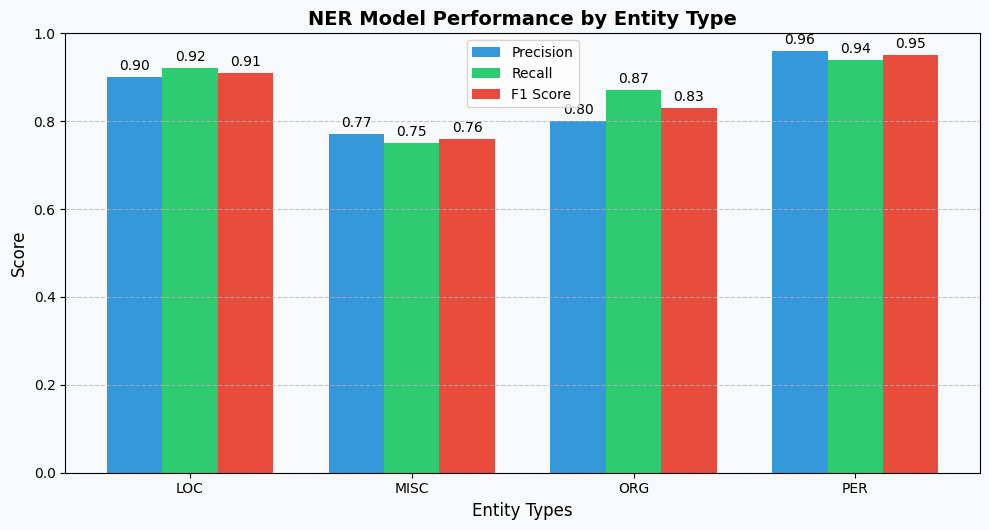

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Results from your evaluation
entity_types = ['LOC', 'MISC', 'ORG', 'PER']
f1_scores = [0.91, 0.76, 0.83, 0.95]
precision = [0.90, 0.77, 0.80, 0.96]
recall = [0.92, 0.75, 0.87, 0.94]

# Set up bar chart
x = np.arange(len(entity_types))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1_scores, width, label='F1 Score', color='#e74c3c')

# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Entity Types', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('NER Model Performance by Entity Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(entity_types, fontsize=10)
ax.set_ylim(0, 1.0)

# Add a horizontal grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)


# Add legend
ax.legend()

# Add a light background color
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('#f8f9fa')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()